In [1]:
import sys
from pathlib import Path
import json

import pandas as pd
import numpy as np
import shapely.geometry as sg
import matplotlib

DIR = Path('..')
sys.path.append(str(DIR))

import gtfstk as gt

DATA_DIR = DIR/'data/'

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/araichev/.virtualenvs/gtfstk-jek8G7uZ/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/araichev/.virtualenvs/gtfstk-jek8G7uZ/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# List feed

path = DATA_DIR/'cairns_gtfs.zip'
gt.list_gtfs(path)

,file_name,file_size
0,calendar_dates.txt,387
1,routes.txt,1478
2,trips.txt,143081
3,stops.txt,26183
4,agency.txt,199
5,stop_times.txt,2561019
6,shapes.txt,864694
7,calendar.txt,337


In [3]:
# Read and print feed

feed = gt.read_gtfs(path, dist_units='km')
print(feed)

* agency --------------------
	                                         agency_name  \
0  Department of Transport and Main Roads - Trans...   

                 agency_url     agency_timezone agency_lang  agency_phone  
0  http://www.sunbus.com.au  Australia/Brisbane          en  (07)40576411  
* calendar --------------------
	                           service_id  monday  tuesday  wednesday  thursday  \
0          CNS2014-CNS_MUL-Weekday-00       1        1          1         1   
1  CNS2014-CNS_MUL-Weekday-00-0000100       0        0          0         0   
2         CNS2014-CNS_MUL-Saturday-00       0        0          0         0   
3           CNS2014-CNS_MUL-Sunday-00       0        0          0         0   

   friday  saturday  sunday start_date  end_date  
0       1         0       0   20140526  20141226  
1       1         0       0   20140530  20141226  
2       0         1       0   20140531  20141227  
3       0         0       1   20140601  20141228  
* calendar_dates ---

In [4]:
feed.describe()

,indicator,value
0,agencies,[Department of Transport and Main Roads - Tran...
1,timezone,Australia/Brisbane
2,start_date,20140526
3,end_date,20141228
4,num_routes,22
5,num_trips,1339
6,num_stops,416
7,num_shapes,54
8,sample_date,20140529
9,num_routes_active_on_sample_date,20


In [5]:
# Validate

feed.validate()

../gtfstk/validators.py:1178: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  g = pd.concat([g, feed.calendar_dates])


,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]
1,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[17710, 17722, 17730, 17732, 17736, 17739, 177..."


In [6]:
# Compute trip stats

trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,703,0,704,705,706
trip_id,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Weekday-00-4165879,CNS2014-CNS_MUL-Weekday-00-4165880,CNS2014-CNS_MUL-Weekday-00-4165881
route_id,110-423,110-423,110-423,110-423,110-423
route_short_name,110,110,110,110,110
route_type,3,3,3,3,3
direction_id,0,0,0,0,0
shape_id,1100023,1100023,1100023,1100023,1100023
num_stops,35,35,35,35,35
start_time,05:50:00,06:16:00,06:20:00,06:50:00,07:15:00
end_time,06:50:00,07:10:00,07:20:00,07:50:00,08:20:00
start_stop_id,750337,750337,750337,750337,750337


In [7]:
# Add shape_dist_traveled column to stop times

feed = feed.append_dist_to_stop_times(trip_stats)
feed.stop_times.head().T

,17709,17710,17711,17712,17713
trip_id,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937
arrival_time,06:16:00,06:16:00,06:18:00,06:20:00,06:21:00
departure_time,06:16:00,06:16:00,06:18:00,06:20:00,06:21:00
stop_id,750337,750000,750001,750002,750003
stop_sequence,1,2,3,4,5
pickup_type,0,0,0,0,0
drop_off_type,0,0,0,0,0
shape_dist_traveled,0,0.46864,1.19038,2.15478,2.619


In [8]:
# Choose study dates

week = feed.get_first_week()
dates = [week[4], week[6]]  # First Friday and Sunday
dates

['20140530', '20140601']

In [9]:
# Compute feed time series

ts = feed.compute_feed_time_series(trip_stats, dates, freq='6H')
ts

,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
2014-05-30 00:00:00,14.0,17.0,17.0,582.579000,12.450000,46.793494
2014-05-30 06:00:00,214.0,240.0,242.0,4954.224929,173.800000,28.505322
2014-05-30 12:00:00,248.0,253.0,281.0,5505.336088,193.216667,28.493070
2014-05-30 18:00:00,155.0,126.0,160.0,3248.283810,103.550000,31.369230
2014-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-01 00:00:00,0.0,0.0,0.0,26.198832,0.766667,34.172389
2014-06-01 06:00:00,68.0,80.0,80.0,1794.087189,55.766667,32.171318


In [10]:
gt.downsample(ts, freq='12H')


,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
2014-05-30 00:00:00,228.0,257.0,256.0,5536.803929,186.250000,29.727806
2014-05-30 12:00:00,403.0,379.0,408.0,8753.619898,296.766667,29.496641
2014-05-31 00:00:00,0.0,0.0,NaN,0.000000,0.000000,NaN
2014-05-31 12:00:00,0.0,0.0,NaN,0.000000,0.000000,NaN
2014-06-01 00:00:00,68.0,80.0,80.0,1820.286021,56.533333,32.198456
2014-06-01 12:00:00,195.0,186.0,198.0,4570.560294,141.150000,32.380873


In [11]:
# Compute feed stats for first week

feed_stats = feed.compute_feed_stats(trip_stats, week)
feed_stats

,date,num_routes,num_stops,num_trip_ends,num_trip_starts,num_trips,peak_end_time,peak_num_trips,peak_start_time,service_distance,service_duration,service_speed
0,20140526,20,416,617,622,622,08:18:00,39,08:16:00,13774.027234,472.600000,29.145212
1,20140527,20,416,617,622,622,08:18:00,39,08:16:00,13774.027234,472.600000,29.145212
2,20140528,20,416,617,622,622,08:18:00,39,08:16:00,13774.027234,472.600000,29.145212
3,20140529,20,416,617,622,622,08:18:00,39,08:16:00,13774.027234,472.600000,29.145212
4,20140530,22,416,617,636,636,08:18:00,39,08:16:00,14290.423827,483.016667,29.585778
5,20140531,22,415,415,437,437,17:37:00,23,17:28:00,9911.526097,310.400000,31.931463
6,20140601,14,411,263,266,266,14:37:00,17,14:31:00,6390.846315,197.683333,32.328706


/home/araichev/.virtualenvs/gtfstk-jek8G7uZ/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/araichev/.virtualenvs/gtfstk-jek8G7uZ/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/araichev/.virtualenvs/gtfstk-jek8G7uZ/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


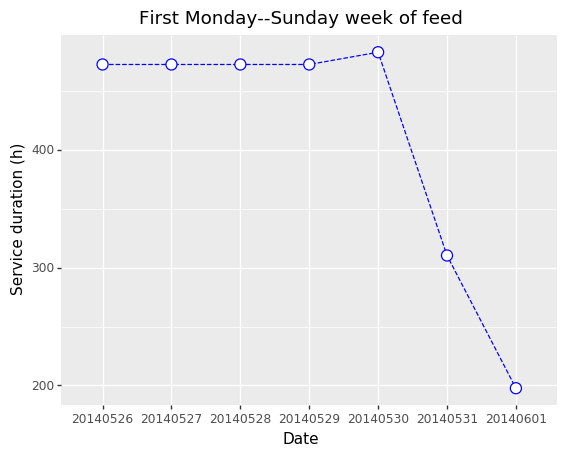

<ggplot: (-9223363294633923980)>

In [12]:
import plotnine as p9

(
    p9.ggplot(feed_stats, p9.aes(x='date', y='service_duration', group=1))
    + p9.geom_line(colour="blue", linetype="dashed")
    + p9.geom_point(colour="blue", size=4, shape='o', fill="white")
    + p9.xlab("Date") 
    + p9.ylab("Service duration (h)")
    + p9.ggtitle("First Monday--Sunday week of feed")
)

In [13]:
# Compute route time series

rts = feed.compute_route_time_series(trip_stats, dates, freq='6H')
rts.head()

indicator           num_trip_ends                                           \
route_id                  110-423 110N-423 111-423 112-423 113-423 120-423   
2014-05-30 00:00:00           0.0      9.0     0.0     0.0     0.0     0.0   
2014-05-30 06:00:00          19.0      0.0    18.0     4.0     3.0    11.0   
2014-05-30 12:00:00          24.0      0.0    24.0     6.0     2.0    12.0   
2014-05-30 18:00:00          15.0      0.0    15.0     5.0     1.0     9.0   
2014-05-31 00:00:00           NaN      NaN     NaN     NaN     NaN     NaN   

indicator                                               ...    service_speed  \
route_id            120N-423 121-423 122-423 123-423    ...         131N-423   
2014-05-30 00:00:00      0.0     0.0     0.0     0.0    ...              NaN   
2014-05-30 06:00:00      0.0    13.0    13.0    21.0    ...              NaN   
2014-05-30 12:00:00      0.0    13.0    12.0    24.0    ...              NaN   
2014-05-30 18:00:00      2.0     8.0     8.0    14.0    ...        24.067374   
2014-05-31 00:00:00      NaN     NaN     NaN     NaN    ...              NaN   

indicator                                                                   \
route_id               133-423    140-423   140N-423    141-423    142-423   
2014-05-30 00:00:00  29.675914  26.255898  46.755126        NaN        NaN   
2014-05-30 06:00:00  24.905870  25.620285        NaN  20.802088  26.021598   
2014-05-30 12:00:00  24.743574  25.593499        NaN  20.809505  26.433521   
2014-05-30 18:00:00  28.375748  26.830956        NaN  21.014223  26.385164   
2014-05-31 00:00:00        NaN        NaN        NaN        NaN        NaN   

indicator                                                       
route_id               143-423   143W-423    150-423  150E-423  
2014-05-30 00:00:00        NaN        NaN        NaN       NaN  
2014-05-30 06:00:00  24.366138        NaN  31.565566       NaN  
2014-05-30 12:00:00  24.377598        NaN  31.524480       NaN  
2014-05-30 18:00:00  23.786714  30.331218  31.702986  34.12138  
2014-05-31 00:00:00        NaN        NaN        NaN       NaN  

[5 rows x 132 columns]

In [14]:
# Slice time series

inds = ['service_distance', 'service_duration', 'service_speed']
rids = ['110-423', '110N-423']

rts.loc[:, (inds, rids)]

indicator           service_distance             service_duration            \
route_id                     110-423    110N-423          110-423  110N-423   
2014-05-30 00:00:00         6.636699  399.508778         0.200000  7.916667   
2014-05-30 06:00:00       671.016117    0.000000        20.816667  0.000000   
2014-05-30 12:00:00       770.365217    0.000000        23.933333  0.000000   
2014-05-30 18:00:00       446.205029    0.000000        12.400000  0.000000   
2014-05-31 00:00:00              NaN         NaN              NaN       NaN   
2014-05-31 06:00:00              NaN         NaN              NaN       NaN   
2014-05-31 12:00:00              NaN         NaN              NaN       NaN   
2014-05-31 18:00:00              NaN         NaN              NaN       NaN   
2014-06-01 00:00:00         2.227621         NaN         0.066667       NaN   
2014-06-01 06:00:00       276.777526         NaN         8.000000       NaN   
2014-06-01 12:00:00       379.349832         NaN        11.000000       NaN   
2014-06-01 18:00:00       353.244573         NaN        10.266667       NaN   

indicator           service_speed             
route_id                  110-423   110N-423  
2014-05-30 00:00:00     33.183495  50.464267  
2014-05-30 06:00:00     32.234561        NaN  
2014-05-30 12:00:00     32.187962        NaN  
2014-05-30 18:00:00     35.984277        NaN  
2014-05-31 00:00:00           NaN        NaN  
2014-05-31 06:00:00           NaN        NaN  
2014-05-31 12:00:00           NaN        NaN  
2014-05-31 18:00:00           NaN        NaN  
2014-06-01 00:00:00     33.414321        NaN  
2014-06-01 06:00:00     34.597191        NaN  
2014-06-01 12:00:00     34.486348        NaN  
2014-06-01 18:00:00     34.406939        NaN

In [15]:
# Compute trip locations for every hour

rng = pd.date_range('1/1/2000', periods=24, freq='H')
times = [t.strftime('%H:%M:%S') for t in rng]
loc = feed.locate_trips(dates[0], times)
loc.head()

,trip_id,time,rel_dist,route_id,direction_id,shape_id,lon,lat
0,CNS2014-CNS_MUL-Weekday-00-4165878,06:00:00,0.152945,110-423,0,1100023,145.669490,-16.762839
1,CNS2014-CNS_MUL-Weekday-00-4165879,07:00:00,0.720587,110-423,0,1100023,145.732413,-16.865060
2,CNS2014-CNS_MUL-Weekday-00-4165880,07:00:00,0.152945,110-423,0,1100023,145.669490,-16.762839
3,CNS2014-CNS_MUL-Weekday-00-4165881,08:00:00,0.720587,110-423,0,1100023,145.732413,-16.865060
4,CNS2014-CNS_MUL-Weekday-00-4165882,08:00:00,0.202283,110-423,0,1100023,145.675422,-16.768954


In [16]:
# Build a route timetable

route_id = feed.routes['route_id'].iat[0]
feed.build_route_timetable(route_id, dates).T

,0,1,2,3,4,5,6,7,8,9,...,30963,30964,30965,30966,30967,30968,30969,30970,30971,30972
route_id,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423,...,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423,110-423
service_id,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,...,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00,CNS2014-CNS_MUL-Sunday-00
trip_id,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,...,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102,CNS2014-CNS_MUL-Sunday-00-4166102
trip_headsign,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,...,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove,Palm Cove
direction_id,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
block_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shape_id,1100023,1100023,1100023,1100023,1100023,1100023,1100023,1100023,1100023,1100023,...,1100016,1100016,1100016,1100016,1100016,1100016,1100016,1100016,1100016,1100016
arrival_time,05:50:00,05:50:00,05:52:00,05:54:00,05:55:00,05:57:00,05:59:00,06:00:00,06:01:00,06:02:00,...,23:50:00,23:51:00,23:52:00,23:54:00,23:54:00,23:56:00,23:59:00,24:01:00,24:02:00,24:04:00
departure_time,05:50:00,05:50:00,05:52:00,05:54:00,05:55:00,05:57:00,05:59:00,06:00:00,06:01:00,06:02:00,...,23:50:00,23:51:00,23:52:00,23:54:00,23:54:00,23:56:00,23:59:00,24:01:00,24:02:00,24:04:00
stop_id,750337,750000,750001,750002,750003,750004,750005,750006,750007,750008,...,750344,750343,750342,750036,750037,750038,750339,750039,750040,750338


In [17]:
# Compute screen line counts

path = DATA_DIR/'cairns_screen_line.geojson'
with path.open() as src:
    line = json.load(src)
    line = sg.shape(line['features'][0]['geometry'])
print(line)

feed.compute_screen_line_counts(line, dates)

LINESTRING (145.7326126098633 -16.84915165200684, 145.7393932342529 -16.84999364745065)


,date,trip_id,route_id,route_short_name,crossing_time,orientation
0,20140530,CNS2014-CNS_MUL-Weekday-00-4166383,120-423,120,05:42:28,-1
1,20140530,CNS2014-CNS_MUL-Weekday-00-4166383,120-423,120,05:50:28,1
2,20140530,CNS2014-CNS_MUL-Weekday-00-4166384,120-423,120,06:42:28,-1
3,20140530,CNS2014-CNS_MUL-Weekday-00-4166384,120-423,120,06:50:28,1
34,20140530,CNS2014-CNS_MUL-Weekday-00-4166400,120-423,120,07:31:32,-1
35,20140530,CNS2014-CNS_MUL-Weekday-00-4166400,120-423,120,07:39:28,1
4,20140530,CNS2014-CNS_MUL-Weekday-00-4166385,120-423,120,07:42:28,-1
5,20140530,CNS2014-CNS_MUL-Weekday-00-4166385,120-423,120,07:50:28,1
36,20140530,CNS2014-CNS_MUL-Weekday-00-4166401,120-423,120,08:31:32,-1
37,20140530,CNS2014-CNS_MUL-Weekday-00-4166401,120-423,120,08:39:28,1


In [18]:
# You need to install Folium for this to work

rids = feed.routes.route_id.loc[2:4]
feed.map_routes(rids)
